In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline




## Make up time series

$$y = 20 + 0.01t + 0.4sin(1\times\frac{2\pi t}{7}) + 0.2cos(1\times\frac{2\pi t}{7}) + 0.1sin(2\times\frac{2\pi t}{7}) + 0.3cos(2\times\frac{2\pi t}{7}) + 0.5sin(3\times\frac{2\pi t}{7}) + 0.7cos(3\times\frac{2\pi t}{7})$$

$$\text{coefficients} = [20, 0.01, 0.4, 0.2, 0.1, 0.3, 0.5, 0.2]$$

In [2]:
ds = pd.date_range(start='2010-01-01', end='2020-01-01').values
t = ds.astype(int)/(60*60*24*1e9)
t_weekly = 2*math.pi*t/7

y = 0.01*t 
y += 0.4*np.sin(1*t_weekly)+0.2*np.cos(1*t_weekly)
y += 0.10*np.sin(2*t_weekly)+0.3*np.cos(2*t_weekly)
y += 0.5*np.sin(3*t_weekly)+0.2*np.cos(3*t_weekly)

In [3]:
data = pd.DataFrame({"ds": ds, "y":y})
data.head()

,ds,y
0,2010-01-01,146.604915
1,2010-01-02,145.875570
2,2010-01-03,146.665183
3,2010-01-04,145.509515
4,2010-01-05,145.994236


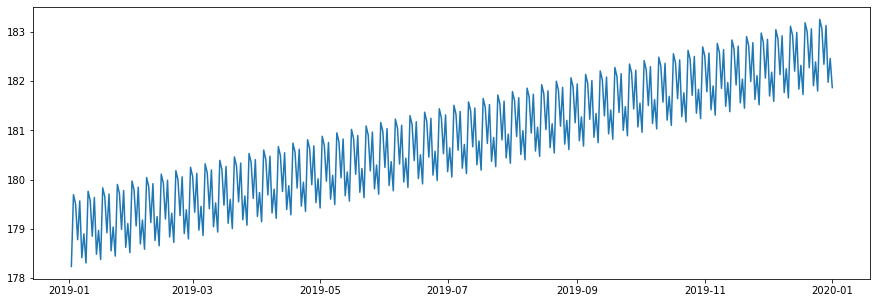

In [4]:
plt.figure(figsize=(15,5))
plt.plot(ds[-365:], y[-365:])
plt.show()

In [5]:
# lots of code taken from 
# https://towardsdatascience.com/linear-regression-with-pytorch-eb6dedead817
import torch
import torch.nn as nn
import torch.optim as optim
import math

class Chronos(nn.Module):
    
    def __init__(self, 
                 criterion=None,
                 optimizer="adam",
                 weekly_seasonality=0,
                 epochs=200):
        super(Chronos, self).__init__()
        
        self.optimizer_name = optimizer
        
        self.criterion = criterion
        if (self.criterion is None):
            self.criterion = nn.MSELoss()
            
        self.weekly_seasonality = weekly_seasonality
        self.epochs = epochs
    
        
    def forward(self, X):
        out = self.linear(X)
        return out.view(-1, 1)
    
    def backward(self, X, y):
        inputs = torch.from_numpy(X)
        labels = torch.from_numpy(y).view(-1,1)
        self.optim.zero_grad()
        
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        
        loss.backward()
        self.optim.step()
        
        return loss
    
    def _prepare_data_from_date(self, X):
        #X.loc[: ,'ts'] = 0
        X.loc[: ,'ts'] = X['ds'].astype(np.int64)/(60*60*24*1e9)

        for o in range(1, self.weekly_seasonality+1):
            #X.loc[:, f'w_sin_{o}'] = 0.0
            #X.loc[:, f'w_cos_{o}'] = 0.0
            X.loc[:, f'w_sin_{o}'] = np.sin(2*math.pi*o*X['ts']/7)
            X.loc[:, f'w_cos_{o}'] = np.cos(2*math.pi*o*X['ts']/7)

        X = X.drop('ds', axis=1)
        
        return X
    
    def fit(self, Y):
        
        X = Y[['ds']].copy()
        X = self._prepare_data_from_date(X)
        y = Y['y'].copy()
        
        #X = np.c_[np.ones(X.shape[0]), X].astype(np.float32)
        
        # if X and y are pandas df
        X = X.values.astype(np.float32)
        y = y.values.astype(np.float32)
        
        
        self.feature_number = X.shape[1]
        self.target_number = 1 if len(y.shape) == 1 else y.shape[1]
        
        
        self.linear = nn.Linear(self.feature_number, self.target_number)
        
        if (self.optimizer_name == "adam"):
            self.optim = optim.Adam(self.parameters(), lr=0.1)
        else:
            raise ValueError(f'Optimizer {self.optimizer_name} is not recognized')
        
        
        for epoch in range(self.epochs):
            self.backward(X, y)
            
            
    def predict(self, X):
        
        
        X = X[['ds']].copy()
        X = self._prepare_data_from_date(X)
        X = X.values.astype(np.float32)
        X = torch.from_numpy(X)
        
        output = self(X)
        
        return output.detach().numpy()
        
        
        
    @property
    def coef_(self):
        
        return self.linear.weight.detach().numpy()
    
    @property
    def const_(self):
        return self.linear.bias.detach().numpy()

In [6]:
my_model = Chronos(weekly_seasonality=3, 
                   epochs=2000)

In [7]:
my_model.fit(data)

In [8]:
my_model.coef_

array([[0.01002339, 0.40001133, 0.19999938, 0.10004047, 0.3000047 ,
        0.49998537, 0.200008  ]], dtype=float32)

In [9]:
my_model.const_

array([-0.38607278], dtype=float32)

In [10]:
y_pred = my_model.predict(data)
y = data['y']

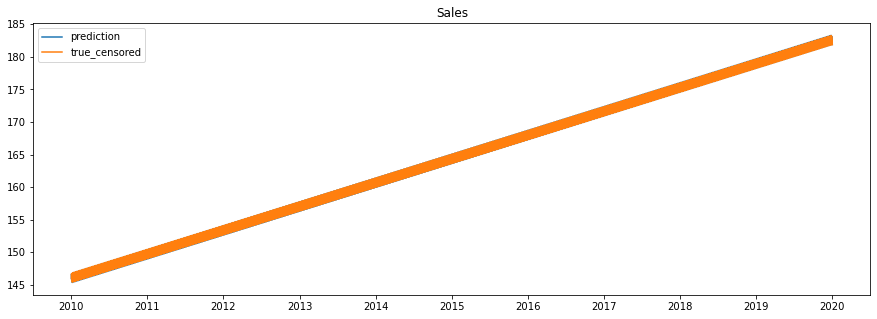

In [11]:
plt.figure(figsize=(15,5))

plt.plot(data['ds'], y_pred, label="prediction")
plt.plot(data['ds'], y, label="true_censored")

plt.title(f'Sales')
plt.legend()
plt.show()

## USING Pyro

In [231]:
# lots of code taken from 
# https://towardsdatascience.com/linear-regression-with-pytorch-eb6dedead817
import torch
import torch.nn as nn
import pyro.optim as optim
import math
import pyro
import pyro.distributions as dist
from pyro.nn import PyroSample
from pyro.nn import PyroModule
from pyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, init_to_mean

from pyro.infer import SVI, Trace_ELBO, Predictive


class Chronos(PyroModule):
    
    def __init__(self, 
                 weekly_seasonality=0,
                 interval=0.2,
                 epochs=200,
                 min_loss=3.0):
        pyro.clear_param_store()
        super(Chronos, self).__init__()
        
        self.weekly_seasonality = weekly_seasonality
        self.epochs = epochs
        self.min_loss = min_loss
        self.interval = interval
    
    #######################################################
    def forward(self, X, y=None):
        
        
        sigma = pyro.sample("sigma", dist.Uniform(0., 1.))
        
        mean = self.linear(X).view(-1)
        
        with pyro.plate("data", X.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean
    #######################################################
    def backward(self, X, y):        
        self.optim.zero_grad()
        
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        
        loss.backward()
        self.optim.step()
        
        return loss
    
    #######################################################
    def _prepare_data_from_date(self, X):
        X.loc[: ,'ts'] = X['ds'].astype(np.int64)/(60*60*24*1e9)

        for o in range(1, self.weekly_seasonality+1):
            X.loc[:, f'w_sin_{o}'] = np.sin(2*math.pi*o*X['ts']/7)
            X.loc[:, f'w_cos_{o}'] = np.cos(2*math.pi*o*X['ts']/7)

        X = X.drop('ds', axis=1)
        
        return X
    
    #######################################################
    def fit(self, Y):
        
        X = Y[['ds']].copy()
        X = self._prepare_data_from_date(X)
        X = X.values.astype(np.float32)
        y = Y['y'].values.astype(np.float32)
        
        
        
        self.feature_number = X.shape[1]
        self.target_number = 1 if len(y.shape) == 1 else y.shape[1]
        
        
        # change the linear layers to be a learnable distribution collection
        self.linear = PyroModule[nn.Linear](self.feature_number, 
                                            self.target_number)
        
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([self.target_number,
                                                                    self.feature_number]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0, 1.0).expand([self.target_number]).to_event(1))
        
        X = torch.from_numpy(X)
        y = torch.from_numpy(y)
        
        
        
        self.guide = AutoDiagonalNormal(self)
        #self.guide = AutoMultivariateNormal(self, init_loc_fn=init_to_mean)
        
        self.optimizer = pyro.optim.ClippedAdam({"lr": 0.001})
        self.inference = SVI(self, self.guide, self.optimizer, loss=Trace_ELBO())
        
        epoch_printout = self.epochs//10
        
        epoch_list = []
        losses_list = []
        
        pyro.clear_param_store()
        for epoch in range(self.epochs):
            # calculate the loss and take a gradient step
            loss = self.inference.step(X, y)
            normalized_loss = loss/X.shape[0]
            if (epoch % epoch_printout == 0):
                print("[iteration %04d] loss: %.4f" % (epoch + 1, normalized_loss))
                
            
                
            epoch_list.append(epoch)
            losses_list.append(loss)
            
            if(normalized_loss < self.min_loss):
                break
            
        return pd.DataFrame({"epoch": epoch_list,
                             "loss": losses_list})
    #######################################################
    def predict(self, X, interval):
        
        
        
        X = X[['ds']].copy()
        X = self._prepare_data_from_date(X)
        X = X.values.astype(np.float32)
        X = torch.from_numpy(X)
        
        predictive = Predictive(self, 
                                guide=self.guide,
                                num_samples=1800,
                                return_sites=("_RETURN",))
        
        samples = predictive(X)
        
        interval_value = (1.0 - interval)/2
        
        
        stats = {}
        for key, values in samples.items():
            interval_number_bottom = int(values.shape[0]*interval_value)
            interval_number_top = int(values.shape[0]*(1.0-interval_value))
            
            
            stats = {"y_hat": torch.mean(values, axis=0).detach().numpy(),
                     "y_hat_std": torch.std(values, axis=0).detach().numpy(),
                     "y_lower": values.kthvalue(interval_number_bottom, axis=0)[0].detach().numpy(),
                     "y_upper": values.kthvalue(interval_number_top, axis=0)[0].detach().numpy()}
        #output = self(X)
        
        return stats
        
        
    #######################################################
    @property
    def coef_(self):
        all_params = pyro.param('guide.loc').detach().numpy()
        
        # The first elements is the sigma we looked at
        coefficients_and_bias = all_params[-self.feature_number-1:]
        
        coefficients = coefficients_and_bias[:self.feature_number] # If there is a bias
                                                        # it's in the last spot
        return coefficients
    
    #######################################################
    @property
    def const_(self):
        all_params = pyro.param('guide.loc').detach().numpy()
        
        # The first elements is the sigma we looked at
        coefficients_and_bias = all_params[-self.feature_number-1:]
        
        bias = coefficients_and_bias[self.feature_number:]
        return bias

In [232]:
my_pyro_model = Chronos(weekly_seasonality=3,
                        epochs=20000,
                        min_loss=0.1)

In [233]:
history = my_pyro_model.fit(data)

[iteration 0001] loss: 48607533.6251
[iteration 2001] loss: 34974.8325
[iteration 4001] loss: 1319.9331
[iteration 6001] loss: 22.4517
[iteration 8001] loss: 3.2032
[iteration 10001] loss: 29.4627
[iteration 12001] loss: 1.6438
[iteration 14001] loss: 22.8521
[iteration 16001] loss: 14.6965
[iteration 18001] loss: 0.9311


In [234]:
pred_dict = my_pyro_model.predict(data, interval=0.99)

In [235]:
y_pred = pred_dict["y_hat"]
y_lower = pred_dict["y_lower"]
y_upper = pred_dict["y_upper"]

In [236]:
my_pyro_model.coef_

array([0.01024305, 0.398423  , 0.20015147, 0.1053616 , 0.30690506,
       0.49762   , 0.20151454], dtype=float32)

In [237]:
my_model.coef_

array([[0.01002339, 0.40001133, 0.19999938, 0.10004047, 0.3000047 ,
        0.49998537, 0.200008  ]], dtype=float32)

In [238]:
my_pyro_model.const_

array([0.04765866], dtype=float32)

In [239]:
y = data['y']

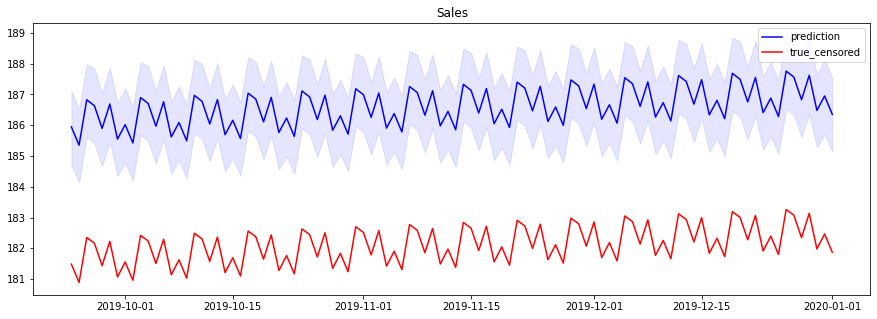

In [240]:
plt.figure(figsize=(15,5))

max_points = 100
plt.plot(data['ds'].iloc[-max_points:], 
         y_pred[-max_points:],
         label="prediction",
         c="blue")
plt.fill_between(data['ds'].iloc[-max_points:],
                 y_lower[-max_points:],
                 y_upper[-max_points:],
                 alpha=0.1,
                 color="blue")
plt.plot(data['ds'].iloc[-max_points:], 
         y[-max_points:], 
         label="true_censored",
         c="red")

plt.title(f'Sales')
plt.legend()
plt.show()

In [23]:
my_data = data[['ds']].iloc[-100:]
my_data['y'] = y[-100:]
my_data['y_pred'] = y_pred[-100:]
my_data['y_lower'] = y_lower[-100:]
my_data['y_upper'] = y_upper[-100:]

my_data

,ds,y,y_pred,y_lower,y_upper
3553,2019-09-24,181.484236,184.098221,168.853577,199.276642
3554,2019-09-25,180.890581,183.535721,168.266495,198.870972
3555,2019-09-26,182.350000,184.869186,169.589554,200.285934
3556,2019-09-27,182.164915,184.719162,169.409027,200.164230
3557,2019-09-28,181.435570,184.084900,168.697342,199.781219
...,...,...,...,...,...
3648,2019-12-28,182.345570,185.006485,169.522812,200.820984
3649,2019-12-29,183.135183,185.757599,170.564529,200.733215
3650,2019-12-30,181.979515,184.570938,169.071472,199.940201
3651,2019-12-31,182.464236,185.090942,169.743179,200.341812


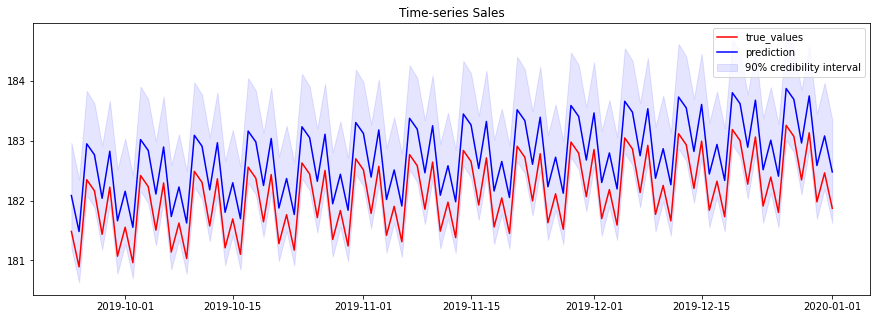

In [127]:
plt.figure(figsize=(15,5))

max_points = 100
plt.plot(my_data['ds'], my_data['y'], label="true_values", c="red")
plt.plot(my_data['ds'], my_data['y_pred'], label="prediction", c="blue")
plt.fill_between(my_data['ds'],
                 my_data['y_lower'],
                 my_data['y_upper'],
                 alpha=0.1,
                 color="blue",
                 label="90% credibility interval")

plt.title(f'Time-series Sales')
plt.legend()
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
X = data.drop(['date','observed_data', 'run_out'], axis=1)
y = data['observed_data']

In [ ]:
import math
week_season_order=3

for i in range(1, week_season_order+1):
    X[f'week_season_{i}'] = np.sin(2*i*math.pi*X['day']/7)+np.cos(2*i*math.pi*X['day']/7)
    
my_lr = LinearRegression()
my_lr.fit(X,y)

y_pred = my_lr.predict(X)

In [ ]:
my_model.coef_

In [ ]:
y_pred = my_model.predict(data)
y = data['y']

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(data['ds'], y_pred, label="prediction")
plt.plot(data['ds'], y, label="true_censored")

plt.title(f'{product_name} Sales')
plt.legend()
plt.show()

In [ ]:
y = data['y']
X = data[['ds']]


X.loc[: ,'ts'] = 0
X.loc[: ,'ts'] = X['ds'].astype(np.int64)/(60*60*24*1e9)

weekly_seasonality = 3
for o in range(1, weekly_seasonality+1):
    X.loc[:, f'w_sin_{o}'] = np.sin(2*math.pi*o*X['ts']/7)
    X.loc[:, f'w_cos_{o}'] = np.cos(2*math.pi*o*X['ts']/7)

X = X.drop('ds', axis=1)
X.head()

In [ ]:
y.head()

In [ ]:
my_model.fit(X,y)

In [ ]:
my_model.coef_

In [ ]:
y_pred = my_model.predict(data)

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(data['ds'], y_pred, label="prediction")
plt.plot(data['ds'], y, label="true_censored")

plt.title(f'{product_name} Sales')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(data['ds'], y_pred, label="prediction")
plt.plot(data['ds'], y, label="true_censored")
#plt.plot(data['ds'], product_df['quantity'], label="true")

plt.title(f'{product_name} Sales')
plt.legend()
plt.show()

In [ ]:





my_ch.fit(data)
y_pred = my_ch.predict(data)
y_pred

plt.figure(figsize=(15,5))

plt.plot(data['ds'], y_pred, label="prediction")
plt.plot(data['ds'], y, label="true_censored")
plt.plot(data['ds'], product_df['quantity'], label="true")

plt.title(f'{product_name} Sales')
plt.legend()
plt.show()

In [ ]:
#lr=0.000000001))

In [ ]:
next(my_ch.parameters())

In [ ]:
from sklearn.linear_model import LinearRegression
X = data.drop(['date','observed_data', 'run_out'], axis=1)
y = data['observed_data']

In [ ]:
import math
week_season_order=10

for i in range(1, week_season_order+1):
    X[f'week_season_{i}'] = np.sin(2*i*math.pi*X['day']/7)+np.cos(2*i*math.pi*X['day']/7)
    
my_lr = LinearRegression()
my_lr.fit(X,y)

y_pred = my_lr.predict(X)

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(data['date'], y_pred, label="prediction")
plt.plot(data['date'], y, label="true_censored")

plt.title(f'{product_name} Sales')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(data['date'], y_pred, label="prediction")
plt.plot(data['date'], product_df['quantity'], label="true")

plt.title(f'{product_name} Sales')
plt.legend()
plt.show()

In [ ]:
import pyro

In [ ]:
import numpy as np
import pandas as pd
import math
import torch.nn as nn

class Chronos(nn.Module):
    
    def __init__(self,
                 weekly_seasonality=0,
                 monthly_seasonality=0,
                 input_size=1,
                 output_size=1):
        super(Chronos, self).__init__()
        torch.manual_seed(0)
        
        self.weekly_seasonality = weekly_seasonality
        self.monthly_seasonality = monthly_seasonality
        self.loss_criterion = nn.MSELoss(reduction='mean')
        
        
    
    def _transform_data_to_tensor(self, Y):
        
        Y_copy = Y.copy()
        
        
        Y_copy['time'] = Y_copy['ds'].astype(np.int64)/(60*60*24*1e9)
        
        
        
        for i in range(1, self.weekly_seasonality+1):
            Y_copy[f'w_sin_{i}'] = np.sin(2*i*math.pi*Y_copy['time']/7)
            Y_copy[f'w_cos_{i}'] = np.cos(2*i*math.pi*Y_copy['time']/7)
            
        for i in range(1, self.monthly_seasonality+1):
            Y_copy[f'm_sin_{i}'] = np.sin(2*i*math.pi*Y_copy['time']/30.5)
            Y_copy[f'm_cos_{i}'] = np.cos(2*i*math.pi*Y_copy['time']/30.5)
            
        Y_copy['time'] = Y_copy['time']/10000
        
        input_target = torch.from_numpy(Y_copy['y'].values.astype(np.float32)).view(-1, 1)
        
        input_data = Y_copy.drop(['ds', 'y', 'censored'], axis=1)
        input_data = torch.from_numpy(input_data.values.astype(np.float32))
        
        return input_data, input_target
        
    def fit(self, Y):
        
        input_data, input_target = self._transform_data_to_tensor(Y)
        
        
        self.coefficents = nn.Linear(input_data.shape[1], 1)
        #print(dir(self.coefficents))
        print(self.coefficents.weight)
        
        #self.opt = optim.SGD(self.parameters(), lr=0.000000001)
        self.opt = optim.SGD(self.parameters(), lr=0.1)
        
        for i in range(200):
            self.backward(input_data, input_target)
        
    def forward(self, x):
        

        output_values = self.coefficents(x)
        
        return output_values
    
    def backward(self, x, y):
        
        
        # zero the parameter gradients
        self.opt.zero_grad()

        # Make a prediction, this calls the forward method
        out = self(x)
        
        #backward
        #print(out)
        loss = self.loss_criterion(out, y)
        #print(loss)
        loss.backward()
        #print(self.parameters().__next__().grad)

        #update
        self.opt.step()
        
        
    def predict(self, Y):
        
        input_data, _ = self._transform_data_to_tensor(Y)
        output_values = self.coefficents(input_data)
        
        return output_values.detach().numpy()
        
        
        
        